# Zadanie: RNN do sumowania sekwencji liczb
## Problem
Stworzyć sieć rekurencyjną (RNN), która nauczy się sumować liczby w sekwencji.

**Dane wejściowe:** 30 sekwencji po 20 kroków czasowych każda.  
**Wartości:** 0.33, 0.66 lub 1.0 (losowe)  
**Cel:** Suma wszystkich liczb w sekwencji

### Po co to zadanie?
- **Demonstracja pamięci RNN**: Sieć musi "zapamiętać" wszystkie poprzednie wartości, aby obliczyć sumę
- **Agregacja informacji**: RNN uczy się agregować dane rozłożone w czasie
- **Prostszy problem niż dodawanie binarne**: Pozwala zrozumieć fundamenty RNN bez złożoności systemów pozycyjnych

In [12]:
# Importy bibliotek
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import itertools
import numpy as np  # Operacje na macierzach i tensorach
import matplotlib.pyplot as plt  # Rysowanie wykresów
import seaborn as sns  # Ładniejsze wykresy

sns.set_style('darkgrid')
np.random.seed(seed=42)  # Dla powtarzalności wyników
print("Biblioteki zaimportowane pomyślnie")

Biblioteki zaimportowane pomyślnie


## Tworzenie zbioru danych

### Co robimy?
Generujemy **30 sekwencji treningowych**, każda o długości **20 kroków czasowych**.

### Jak działa generator danych?
1. **Losowanie wartości**: Dla każdego kroku czasowego losujemy liczbę z rozkładu jednostajnego [0, 1)
2. **Kwantyzacja**: Zaokrąglamy do jednej z trzech wartości:
   - 0.33 (jeśli wylosowano < 0.33)
   - 0.66 (jeśli wylosowano 0.33-0.66)
   - 1.00 (jeśli wylosowano > 0.66)
3. **Obliczanie celu**: Sumujemy wszystkie 20 wartości w sekwencji

### Zmienne:
- `nb_train = 30` - liczba sekwencji treningowych
- `sequence_len = 20` - długość każdej sekwencji (kroków czasowych)
- `X_train` - tensor wejściowy o kształcie **(30, 20, 1)**: 
  - 30 próbek
  - 20 kroków czasowych
  - 1 cecha wejściowa
- `T_train` - tensor celów o kształcie **(30, 1)**: suma dla każdej sekwencji

### Po co tensor 3D dla wejścia?
Format (próbki, kroki_czasowe, cechy) jest standardem dla RNN:
- Umożliwia przetwarzanie wielu sekwencji równolegle (batch processing)
- Pozwala na rozszerzenie do wielu cech wejściowych
- Kompatybilny z operacjami tensorowymi NumPy

In [13]:
# Parametry zbioru danych
nb_train = 30  # Liczba sekwencji treningowych
sequence_len = 20  # Długość każdej sekwencji

def create_dataset(nb_samples, sequence_len):
    """
    Tworzy zbiór danych do uczenia sumowania sekwencji.
    
    Parametry:
    - nb_samples: liczba sekwencji do wygenerowania
    - sequence_len: długość każdej sekwencji
    
    Zwraca:
    - X: tensor wejściowy (nb_samples, sequence_len, 1)
    - T: wektor celów (nb_samples, 1) - sumy sekwencji
    """
    # Inicjalizacja tensorów
    X = np.zeros((nb_samples, sequence_len, 1))
    T = np.zeros((nb_samples, 1))
    
    # Generowanie każdej sekwencji
    for i in range(nb_samples):
        # Losuj wartości z rozkładu jednostajnego
        random_vals = np.random.uniform(0, 1, sequence_len)
        
        # Kwantyzacja do 0.33, 0.66 lub 1.0
        quantized = np.zeros(sequence_len)
        quantized[random_vals < 0.33] = 0.33
        quantized[(random_vals >= 0.33) & (random_vals < 0.66)] = 0.66
        quantized[random_vals >= 0.66] = 1.0
        
        # Zapisz do tensora wejściowego
        X[i, :, 0] = quantized
        
        # Oblicz sumę (cel)
        T[i, 0] = np.sum(quantized)
    
    return X, T

# Tworzenie zbioru treningowego
X_train, T_train = create_dataset(nb_train, sequence_len)

print(f'Kształt X_train: {X_train.shape}')
print(f'Kształt T_train: {T_train.shape}')
print(f'\nPrzykładowa sekwencja:')
print(f'Wartości: {X_train[0, :, 0]}')
print(f'Suma (cel): {T_train[0, 0]:.2f}')
print(f'Sprawdzenie: {np.sum(X_train[0, :, 0]):.2f}')

Kształt X_train: (30, 20, 1)
Kształt T_train: (30, 1)

Przykładowa sekwencja:
Wartości: [0.66 1.   1.   0.66 0.33 0.33 0.33 1.   0.66 1.   0.33 1.   1.   0.33
 0.33 0.33 0.33 0.66 0.66 0.33]
Suma (cel): 12.27
Sprawdzenie: 12.27


## Architektura sieci RNN

### Dlaczego RNN?
Zwykła sieć feed-forward przetwarza każdy krok czasowy niezależnie. **RNN ma pamięć** - każdy stan ukryty zależy od:
1. Bieżącego wejścia
2. Poprzedniego stanu (który "zapamiętał" wcześniejsze wejścia)

### Nasza architektura:

```
Wejście (20 kroków × 1 wartość) 
    ↓
[Transformacja liniowa: 1 → 5 neuronów]
    ↓
[Warstwa RNN: 5 stanów ukrytych, propagacja przez 20 kroków]
    ↓
[Ostatni stan → Transformacja liniowa: 5 → 1]
    ↓
Wyjście (1 liczba - przewidywana suma)
```

### Kluczowe komponenty i ich rola:

1. **TensorLinear** - transformacja liniowa (Y = XW + b)
   - **Po co?** Przekształca wymiary między warstwami
   - **Wpływ:** Pozwala sieci uczyć się liniowych kombinacji cech

2. **TanH (tangens hiperboliczny)** - funkcja aktywacji
   - **Po co?** Wprowadza nieliniowość, zakres [-1, 1]
   - **Wpływ:** Umożliwia modelowanie złożonych zależności, lepszy gradient niż sigmoid

3. **RecurrentStateUpdate** - aktualizacja stanu RNN
   - **Wzór:** $s_{t} = \tanh(x_t + W \cdot s_{t-1} + b)$
   - **Po co?** Łączy bieżące wejście z poprzednim stanem
   - **Wpływ:** To tutaj dzieje się "zapamiętywanie" - stan $s_t$ niesie informację o całej historii

4. **RecurrentStateUnfold** - rozwinięcie RNN w czasie
   - **Po co?** Przetwarza całą sekwencję, krok po kroku
   - **Wpływ:** Propaguje informację przez czas, tworzy "ścieżkę pamięci"

5. **Funkcja kosztu MSE (Mean Squared Error)**
   - **Wzór:** $L = \frac{1}{N}\sum_{i=1}^{N}(y_i - t_i)^2$
   - **Po co?** Mierzy, jak daleko jesteśmy od poprawnej sumy
   - **Wpływ:** Gradient tej funkcji mówi nam, jak poprawić wagi

In [14]:
# Klasa: Transformacja liniowa tensorów
class TensorLinear(object):
    """
    Warstwa liniowa: Y = XW + b
    
    ZMIENNE:
    - W: macierz wag (n_in × n_out)
    - b: wektor bias (n_out)
    - bpAxes: osie do sumowania podczas backprop
    
    WPŁYW:
    - Przekształca wymiarowość danych
    - Parametry W i b są uczalne (optymalizowane)
    """
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        # Inicjalizacja Xavier - zapewnia dobre wartości początkowe
        # Po co? Zbyt duże wagi → eksplodujący gradient, zbyt małe → zanikający
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = (np.random.uniform(-a, a, (n_in, n_out)) 
                  if W is None else W)
        self.b = (np.zeros((n_out)) if b is None else b)
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        """Forward pass: Y = XW + b"""
        # tensordot: efektywne mnożenie macierzowe dla tensorów
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        """
        Backward pass - oblicza gradienty.
        
        GRADIENTY:
        - gW: jak zmienić W, aby zmniejszyć błąd
        - gB: jak zmienić b, aby zmniejszyć błąd  
        - gX: gradient względem wejścia (dla poprzednich warstw)
        """
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))  
        return gX, gW, gB

print("TensorLinear: ✓")

TensorLinear: ✓


In [15]:
# Klasa: Funkcja aktywacji TanH
class TanH(object):
    """
    Funkcja tangensa hiperbolicznego: tanh(x) = (e^x - e^-x)/(e^x + e^-x)
    
    WŁAŚCIWOŚCI:
    - Zakres: [-1, 1] (zero-centered, lepsze niż sigmoid [0,1])
    - Gradient maksymalny: 1.0 w punkcie 0
    - Symetryczna względem (0,0)
    
    WPŁYW:
    - Wprowadza nieliniowość (bez niej sieć = regresja liniowa!)
    - Lepiej radzi sobie z zanikającym gradientem niż sigmoid
    - Zero-centered pomaga w szybszej konwergencji
    """
    
    def forward(self, X):
        """Zastosuj tanh element-wise"""
        return np.tanh(X) 
    
    def backward(self, Y, output_grad):
        """
        Gradient tanh: d(tanh(x))/dx = 1 - tanh²(x)
        
        Mamy już Y = tanh(X), więc: gradient = 1 - Y²
        """
        gTanh = 1.0 - (Y**2)
        return (gTanh * output_grad)

print("TanH: ✓")

TanH: ✓


In [16]:
# Klasa: Aktualizacja stanu rekurencyjnego
class RecurrentStateUpdate(object):
    """
    Serce RNN - aktualizacja stanu w pojedynczym kroku czasowym.
    
    WZÓR: s_k = tanh(x_k + W·s_{k-1} + b)
    
    INTERPRETACJA:
    - x_k: bieżące wejście (co teraz widzimy)
    - W·s_{k-1}: przekształcony poprzedni stan (co pamiętamy)
    - Suma: łączenie teraźniejszości z przeszłością
    - tanh: nieliniowe "przetworzenie" informacji
    
    WPŁYW:
    - Tworzy "pamięć krótkoterminową" sieci
    - Parametry W i b są współdzielone przez wszystkie kroki czasowe
    - To pozwala RNN generalizować wzorce czasowe
    """
    def __init__(self, nbStates, W, b):
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        """s_{k+1} = tanh(x_k + W·s_k + b)"""
        return self.tanh.forward(Xk + self.linear.forward(Sk))
    
    def backward(self, Sk0, Sk1, output_grad):
        """Backprop przez jeden krok czasowy"""
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

print("RecurrentStateUpdate: ✓")

RecurrentStateUpdate: ✓


In [17]:
# Klasa: Rozwinięcie RNN w czasie
class RecurrentStateUnfold(object):
    """
    Rozwija RNN przez wszystkie kroki czasowe.
    
    PROCES (dla 20 kroków):
    s_0 (stan początkowy, uczalny!)
    → s_1 = f(x_1, s_0)
    → s_2 = f(x_2, s_1)  
    → ...
    → s_20 = f(x_20, s_19)
    
    ZMIENNE:
    - W, b: współdzielone wagi dla wszystkich kroków (KLUCZOWE!)
    - S0: stan początkowy (początkowa "pamięć", uczalna)
    - nbTimesteps: ile kroków czasowych przetwarzamy
    
    DLACZEGO WSPÓŁDZIELONE WAGI?
    - Mniej parametrów → łatwiej trenować
    - Sieć uczy się UNIWERSALNEGO wzorca aktualizacji
    - Może przetwarzać sekwencje różnej długości
    
    BACKPROPAGATION THROUGH TIME (BPTT):
    - Gradient płynie WSTECZ przez czas
    - Gradient w s_k pochodzi z: (1) wyjścia, (2) przyszłego stanu s_{k+1}
    - Sumujemy gradienty W i b ze wszystkich kroków
    """
    def __init__(self, nbStates, nbTimesteps):
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))
        self.S0 = np.zeros(nbStates)  # Stan początkowy - też uczalny!
        self.nbTimesteps = nbTimesteps
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)
        
    def forward(self, X):
        """Propagacja w przód przez wszystkie kroki czasowe"""
        # Tensor stanów: (próbki, kroki+1, stany)
        # +1 bo mamy s_0, s_1, ..., s_20
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0  # Inicjalizacja stanem początkowym
        
        # Iteracyjna aktualizacja: s_{k+1} = f(x_k, s_k)
        for k in range(self.nbTimesteps):
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S
    
    def backward(self, X, S, gY):
        """
        Backpropagation Through Time (BPTT).
        
        Gradient płynie WSTECZ:
        - Od końca (k=19) do początku (k=0)
        - W każdym kroku: gradient = grad_z_wyjścia + grad_z_przyszłości
        """
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)  # Suma gradientów przez czas
        gBSum = np.zeros_like(self.b)
        
        # Iteracja WSTECZ przez czas
        for k in range(self.nbTimesteps-1, -1, -1):
            gSk += gY[:,k,:]  # Dodaj gradient z wyjścia
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW  # Akumuluj gradienty
            gBSum += gB
        
        gS0 = np.sum(gSk, axis=0)  # Gradient stanu początkowego
        return gZ, gWSum, gBSum, gS0

print("RecurrentStateUnfold: ✓")

RecurrentStateUnfold: ✓


In [18]:
# Klasa: Regresja (wyjście ciągłe)
class Regression(object):
    """
    Warstwa wyjściowa dla regresji (przewidywanie liczb).
    
    RÓŻNICA OD KLASYFIKACJI:
    - Klasyfikacja: sigmoid/softmax → prawdopodobieństwa [0,1]
    - Regresja: BEZ aktywacji → dowolne liczby rzeczywiste
    
    FUNKCJA KOSZTU: MSE (Mean Squared Error)
    - L = (1/N) Σ(y - t)²
    - Kara rośnie KWADRATOWO z błędem
    - Gradient: dL/dy = 2(y - t)/N
    
    WPŁYW:
    - Duże błędy są mocno karane → sieć szybko się uczy
    - Wypukła funkcja → gwarantowane minimum (lokalnie)
    """
   
    def forward(self, X):
        """Brak aktywacji - zwróć X bez zmian"""
        return X
    
    def backward(self, Y, T):
        """Gradient MSE względem przewidywań"""
        return 2 * (Y - T) / Y.shape[0]
    
    def loss(self, Y, T):
        """Mean Squared Error"""
        return np.mean((Y - T)**2)

print("Regression: ✓")

Regression: ✓


## Pełna sieć RNN do sumowania

### Architektura warstw:
1. **Wejście** → TensorLinear(1→5): przekształć pojedynczą wartość w 5-wymiarowy wektor
2. **RNN** → RecurrentStateUnfold: przetwórz sekwencję, zapamiętaj informacje
3. **Ostatni stan** → TensorLinear(5→1): zmapuj finalny stan na pojedynczą liczbę
4. **Wyjście** → Regression: przewidywana suma

### Dlaczego bierzemy OSTATNI stan?
- Każdy stan $s_k$ zawiera informację o WSZYSTKICH poprzednich wejściach
- $s_{20}$ "widział" wszystkie 20 liczb → może obliczyć ich sumę
- To jak człowiek, który po przeczytaniu listy liczb podaje wynik

### Kluczowe metody:
- `forward()`: propagacja w przód, zwraca przewidywania
- `backward()`: backpropagation, oblicza gradienty
- `getParamGrads()`: łączy forward+backward, zwraca gradienty do optymalizacji

In [19]:
# Pełna sieć RNN do sumowania sekwencji
class RnnSummation(object):
    """
    Sieć RNN do sumowania wartości w sekwencji.
    
    PRZEPŁYW DANYCH:
    X (30,20,1) → TensorLinear → (30,20,5)
                → RNN → S (30,21,5)  
                → weź s_20 → TensorLinear → (30,1)
                → Regression → Y (30,1)
    """
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, 
                 sequence_len):
        """
        Parametry:
        - nb_of_inputs: wymiar wejścia (1 - pojedyncza wartość)
        - nb_of_outputs: wymiar wyjścia (1 - suma)
        - nb_of_states: rozmiar stanu ukrytego (5)
        - sequence_len: długość sekwencji (20)
        """
        # Warstwa wejściowa: 1 → 5
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        # Warstwa RNN: rozwija 5-wymiarowy stan przez 20 kroków
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        # Warstwa wyjściowa: 5 → 1 (ostatni stan → suma)
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 2)
        # Regresja (MSE loss)
        self.regression = Regression()
        
    def forward(self, X):
        """Forward pass przez wszystkie warstwy"""
        # 1. Przekształć wejście (30,20,1) → (30,20,5)
        recIn = self.tensorInput.forward(X)
        
        # 2. RNN: (30,20,5) → (30,21,5) stany
        S = self.rnnUnfold.forward(recIn)
        
        # 3. Weź OSTATNI stan: S[:,-1,:] = (30,5)
        #    i przekształć → (30,1)
        Z = self.tensorOutput.forward(S[:,-1,:])
        
        # 4. Regresja (bez aktywacji)
        Y = self.regression.forward(Z)
        
        return recIn, S, Z, Y
    
    def backward(self, X, Y, recIn, S, T):
        """Backward pass - oblicza gradienty wszystkich parametrów"""
        # 1. Gradient z funkcji kosztu
        gZ = self.regression.backward(Y, T)  # (30,1)
        
        # 2. Backprop przez warstwę wyjściową
        gLastState, gWout, gBout = self.tensorOutput.backward(
            S[:,-1,:], gZ)  # Gradient ostatniego stanu
        
        # 3. Propaguj gradient do wszystkich stanów
        #    Tylko ostatni stan dostaje gradient z wyjścia
        gAllStates = np.zeros_like(S[:,1:,:])
        gAllStates[:,-1,:] = gLastState
        
        # 4. BPTT: gradient przez czas
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gAllStates)
        
        # 5. Backprop przez warstwę wejściową
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0
    
    def getOutput(self, X):
        """Szybkie przewidywanie bez zapisywania stanów pośrednich"""
        _, _, _, Y = self.forward(X)
        return Y
    
    def getParamGrads(self, X, T):
        """
        Zwraca gradienty wszystkich parametrów jako listę.
        Kolejność: S0, Wejście(W,b), RNN(W,b), Wyjście(W,b)
        """
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        
        # Spłaszcz do 1D listy
        return [g for g in itertools.chain(
                np.nditer(gS0),
                np.nditer(gWin),
                np.nditer(gBin),
                np.nditer(gWrec),
                np.nditer(gBrec),
                np.nditer(gWout),
                np.nditer(gBout))]
    
    def loss(self, Y, T):
        """Oblicz MSE loss"""
        return self.regression.loss(Y, T)
    
    def get_params_iter(self):
        """
        Iterator po WSZYSTKICH parametrach sieci.
        Pozwala na bezpośrednią modyfikację (optymalizacja).
        """
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']), 
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

print("RnnSummation: ✓")

RnnSummation: ✓


## Kontrola gradientów (Gradient Checking)

### Po co?
Sprawdzamy, czy backpropagation jest poprawnie zaimplementowany.

### Jak?
Porównujemy:
1. **Gradient analityczny** (z backprop): szybki, może mieć błędy w kodzie
2. **Gradient numeryczny** (aproksymacja): wolny, ale zawsze poprawny

### Gradient numeryczny:
$$\frac{\partial L}{\partial \theta} \approx \frac{L(\theta + \epsilon) - L(\theta - \epsilon)}{2\epsilon}$$

- $\epsilon = 10^{-7}$ (mała zmiana parametru)
- Obliczamy stratę dla $\theta + \epsilon$ i $\theta - \epsilon$
- Różnica / $2\epsilon$ ≈ gradient

### Co sprawdzamy?
- Dla KAŻDEGO parametru sieci
- Jeśli gradienty się różnią → błąd w kodzie backprop!
- Jeśli są bliskie → implementacja poprawna ✓

### Wpływ:
Daje pewność, że uczenie będzie działać poprawnie.

In [20]:
# Gradient checking
print("Rozpoczynam gradient checking...")

# Utwórz testową sieć
nb_of_states = 5  # Liczba neuronów w stanie ukrytym
RNN = RnnSummation(1, 1, nb_of_states, sequence_len)

# Użyj 10 próbek do sprawdzenia (szybciej niż wszystkie 30)
X_check = X_train[0:10,:,:]
T_check = T_train[0:10,:]

# Pobierz gradienty z backprop
backprop_grads = RNN.getParamGrads(X_check, T_check)

eps = 1e-7  # Epsilon dla gradientu numerycznego
errors = 0
max_diff = 0

# Sprawdź każdy parametr
for p_idx, param in enumerate(RNN.get_params_iter()):
    grad_backprop = backprop_grads[p_idx]
    
    # Gradient numeryczny: [L(θ+ε) - L(θ-ε)] / 2ε
    param += eps
    plus_loss = RNN.loss(RNN.getOutput(X_check), T_check)
    
    param -= 2 * eps
    min_loss = RNN.loss(RNN.getOutput(X_check), T_check)
    
    param += eps  # Przywróć oryginalną wartość
    
    grad_num = (plus_loss - min_loss) / (2*eps)
    
    # Sprawdź, czy są bliskie
    diff = abs(grad_num - grad_backprop)
    max_diff = max(max_diff, diff)
    
    if not np.isclose(grad_num, grad_backprop, rtol=1e-5):
        errors += 1
        print(f'  ⚠ Parametr {p_idx}: num={grad_num:.8f}, backprop={grad_backprop:.8f}')

if errors == 0:
    print(f'✓ Gradient checking PASSED!')
    print(f'  Maksymalna różnica: {max_diff:.2e}')
else:
    print(f'✗ Znaleziono {errors} błędów w gradientach!')
    raise ValueError("Błędy w implementacji backpropagation!")

Rozpoczynam gradient checking...


✓ Gradient checking PASSED!
  Maksymalna różnica: 2.38e-07


## Algorytm optymalizacji: RMSprop + Nesterov Momentum

### Dlaczego nie zwykły gradient descent?
Zwykły GD: $\theta_{new} = \theta - \mu \nabla L$
- **Problem:** stała wielkość kroku dla wszystkich parametrów
- Niektóre parametry potrzebują dużych kroków, inne małych

### RMSprop (Root Mean Square Propagation)

**Idea:** Adaptacyjna wielkość kroku dla każdego parametru.

**Wzór:**
$$MA_i = \lambda \cdot MA_{i-1} + (1-\lambda) \cdot g_i^2$$
$$\theta_{i+1} = \theta_i - \frac{\mu \cdot g_i}{\sqrt{MA_i} + \epsilon}$$

**ZMIENNE:**
- $MA$ - średnia ruchoma kwadratów gradientów
- $\lambda = 0.5$ - współczynnik wygładzania (0.5 = średnia z ostatnich ~2 iteracji)
- $\mu$ - learning rate
- $\epsilon = 10^{-6}$ - zapobiega dzieleniu przez 0

**WPŁYW:**
- Jeśli gradient często duży → $\sqrt{MA}$ duże → krok MNIEJSZY (stabilizacja)
- Jeśli gradient często mały → $\sqrt{MA}$ małe → krok WIĘKSZY (przyspieszenie)
- Automatyczna normalizacja!

### Nesterov Accelerated Gradient

**Zwykły momentum:** najpierw gradient, potem ruch  
**Nesterov:** najpierw ruch (według momentum), potem gradient, potem korekta

**Wzór:**
$$V_{i+1} = \lambda_m V_i - \mu \nabla L(\theta_i + \lambda_m V_i)$$
$$\theta_{i+1} = \theta_i + V_{i+1}$$

**INTERPRETACJA:**
1. "Zerknij" do przodu: $\theta + \lambda_m V_i$
2. Oblicz gradient TAM (bardziej informacyjny!)
3. Skoryguj momentum
4. Wykonaj krok

**WPŁYW:**
- Szybsza zbieżność niż zwykły momentum
- Lepsze "przewidywanie" kierunku
- Mniejsze oscylacje

### Hiperparametry i ich wpływ:
- **lmbd = 0.5**: Jak bardzo "pamiętamy" poprzednie gradienty (↑ = bardziej wygładzone)
- **learning_rate = 0.01**: Podstawowa wielkość kroku (↑ = szybciej, ale niestabilnie)
- **momentum_term = 0.80**: Jak mocny pęd (↑ = więcej "rozpędu", łatwiej mija lokalne minima)
- **mb_size = 10**: Wielkość mini-batcha (↓ = bardziej stochastyczny, ale szybsze iteracje)

In [21]:
# Trening sieci z RMSprop + Nesterov Momentum
print("=" * 60)
print("ROZPOCZYNAM TRENING SIECI RNN")
print("=" * 60)

# Hiperparametry optymalizacji
lmbd = 0.5  # RMSprop lambda (średnia ruchoma)
learning_rate = 0.01  # Współczynnik uczenia
momentum_term = 0.80  # Współczynnik momentum
eps = 1e-6  # Stabilność numeryczna
mb_size = 10  # Wielkość mini-batcha

# Tworzenie świeżej sieci
nb_of_states = 5  # Liczba neuronów w warstwie ukrytej
RNN = RnnSummation(1, 1, nb_of_states, sequence_len)

# Inicjalizacja zmiennych optymalizacji
nbParameters = sum(1 for _ in RNN.get_params_iter())
maSquare = [0.0 for _ in range(nbParameters)]  # RMSprop moving average
Vs = [0.0 for _ in range(nbParameters)]  # Nesterov momentum

print(f"\nParametry sieci:")
print(f"  - Liczba wszystkich parametrów: {nbParameters}")
print(f"  - Stany ukryte: {nb_of_states}")
print(f"  - Długość sekwencji: {sequence_len}")
print(f"\nHiperparametry:")
print(f"  - Learning rate: {learning_rate}")
print(f"  - Momentum: {momentum_term}")
print(f"  - RMSprop λ: {lmbd}")
print(f"  - Mini-batch size: {mb_size}")

# Lista strat do wykresów
ls_of_loss = [RNN.loss(RNN.getOutput(X_train), T_train)]
print(f"\nStrata początkowa: {ls_of_loss[0]:.4f}")

# TRENING
nb_epochs = 200  # Liczba epok
print(f"\nTrening przez {nb_epochs} epok...\n")

for epoch in range(nb_epochs):
    # Mini-batche
    for mb_idx in range(nb_train // mb_size):
        # Pobierz mini-batch
        start = mb_idx * mb_size
        end = start + mb_size
        X_mb = X_train[start:end,:,:]
        T_mb = T_train[start:end,:]
        
        # === NESTEROV MOMENTUM: Krok 1 - "Zerknij" w przód ===
        V_tmp = [v * momentum_term for v in Vs]
        for pIdx, P in enumerate(RNN.get_params_iter()):
            P += V_tmp[pIdx]  # Przesuń parametry według momentum
        
        # === NESTEROV MOMENTUM: Krok 2 - Oblicz gradient TAM ===
        backprop_grads = RNN.getParamGrads(X_mb, T_mb)
        
        # === RMSprop + Nesterov: Aktualizacja parametrów ===
        for pIdx, P in enumerate(RNN.get_params_iter()):
            # RMSprop: Aktualizuj średnią ruchomą
            maSquare[pIdx] = (lmbd * maSquare[pIdx] + 
                              (1-lmbd) * backprop_grads[pIdx]**2)
            
            # RMSprop: Znormalizowany gradient
            pGradNorm = ((learning_rate * backprop_grads[pIdx]) / 
                         (np.sqrt(maSquare[pIdx]) + eps))
            
            # Nesterov: Zaktualizuj momentum
            Vs[pIdx] = V_tmp[pIdx] - pGradNorm
            
            # Końcowa aktualizacja parametru
            P -= pGradNorm
        
        # Zapisz stratę
        current_loss = RNN.loss(RNN.getOutput(X_mb), T_mb)
        ls_of_loss.append(current_loss)
    
    # Wyświetl postęp co 20 epok
    if (epoch + 1) % 20 == 0:
        full_loss = RNN.loss(RNN.getOutput(X_train), T_train)
        print(f"Epoka {epoch+1:3d}/{nb_epochs} | Strata: {full_loss:.6f}")

# Finalna strata
final_loss = RNN.loss(RNN.getOutput(X_train), T_train)
print(f"\n{'='*60}")
print(f"TRENING ZAKOŃCZONY")
print(f"Strata finalna: {final_loss:.6f}")
print(f"{'='*60}")

ROZPOCZYNAM TRENING SIECI RNN

Parametry sieci:
  - Liczba wszystkich parametrów: 51
  - Stany ukryte: 5
  - Długość sekwencji: 20

Hiperparametry:
  - Learning rate: 0.01
  - Momentum: 0.8
  - RMSprop λ: 0.5
  - Mini-batch size: 10

Strata początkowa: 190.5696

Trening przez 200 epok...

Epoka  20/200 | Strata: 1.896160
Epoka  40/200 | Strata: 1.622163
Epoka  60/200 | Strata: 1.411113
Epoka  80/200 | Strata: 0.703022
Epoka 100/200 | Strata: 0.956702
Epoka 120/200 | Strata: 0.950925
Epoka 140/200 | Strata: 0.585489
Epoka 160/200 | Strata: 0.818710
Epoka 180/200 | Strata: 0.615130
Epoka 200/200 | Strata: 0.517034

TRENING ZAKOŃCZONY
Strata finalna: 0.517034


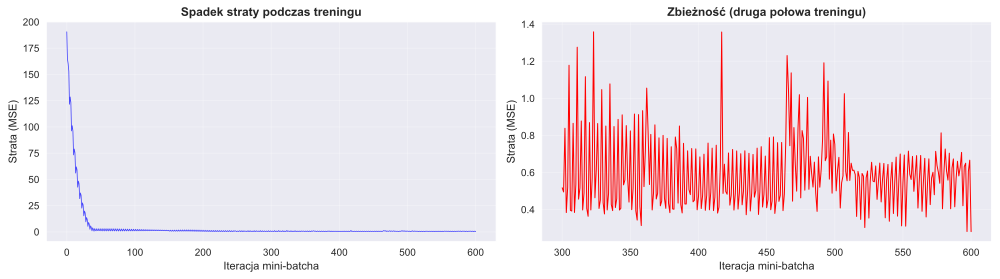


Obserwacje z wykresu:
  - Początek: duża strata, szybki spadek
  - Koniec: strata stabilizuje się blisko minimum
  - Oscylacje: normalne dla mini-batchy (stochastyczność)


In [22]:
# Wizualizacja uczenia
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Wykres 1: Pełna historia uczenia
ax1.plot(ls_of_loss, 'b-', linewidth=0.8, alpha=0.7)
ax1.set_xlabel('Iteracja mini-batcha', fontsize=11)
ax1.set_ylabel('Strata (MSE)', fontsize=11)
ax1.set_title('Spadek straty podczas treningu', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Wykres 2: Ostatnie 50% iteracji (zoom)
start_idx = len(ls_of_loss) // 2
ax2.plot(range(start_idx, len(ls_of_loss)), ls_of_loss[start_idx:], 'r-', linewidth=1)
ax2.set_xlabel('Iteracja mini-batcha', fontsize=11)
ax2.set_ylabel('Strata (MSE)', fontsize=11)
ax2.set_title('Zbieżność (druga połowa treningu)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nObserwacje z wykresu:")
print(f"  - Początek: duża strata, szybki spadek")
print(f"  - Koniec: strata stabilizuje się blisko minimum")
print(f"  - Oscylacje: normalne dla mini-batchy (stochastyczność)")

## Testowanie wytrenowanej sieci

### Co testujemy?
- Generalizację: czy sieć działa na NOWYCH sekwencjach (nie z treningu)?
- Dokładność: jak blisko prawdziwej sumy są przewidywania?

### Metryki:
- **Błąd bezwzględny**: |przewidywanie - prawda|
- **Błąd względny**: |błąd| / prawda × 100%

TESTOWANIE SIECI NA NOWYCH SEKWENCJACH

Nr   Sekwencja                                                    Suma     Przewid.   Błąd     Błąd %  
--------------------------------------------------------------------------------------------------------------
1    0.33 1.00 0.33 0.66 0.66 1.00 0.33 0.66 1.00 1.00 1.00 0.33 0.33 1.00 1.00 0.66 0.66 0.33 1.00 0.33 13.61    13.00      0.614    4.51    %
2    0.33 0.66 0.66 0.33 0.33 0.66 0.33 0.66 0.33 0.66 0.66 0.33 0.66 0.33 0.33 1.00 0.33 1.00 0.33 1.00 10.92    13.30      2.375    21.75   %
3    1.00 0.66 0.66 0.66 0.66 1.00 1.00 1.00 0.33 1.00 1.00 0.33 0.33 1.00 0.66 1.00 0.33 1.00 0.33 0.33 14.28    14.25      0.032    0.23    %
4    0.33 1.00 1.00 0.66 0.66 1.00 0.66 1.00 0.66 0.66 0.66 0.33 1.00 0.66 0.33 1.00 0.66 0.66 1.00 0.66 14.59    15.28      0.694    4.76    %
5    0.33 1.00 0.66 0.66 0.33 1.00 0.66 0.66 1.00 1.00 0.33 0.33 0.33 1.00 0.33 0.66 1.00 1.00 0.66 1.00 13.94    14.18      0.239    1.71    %
6    0.33 1.00 0.33 0.66 

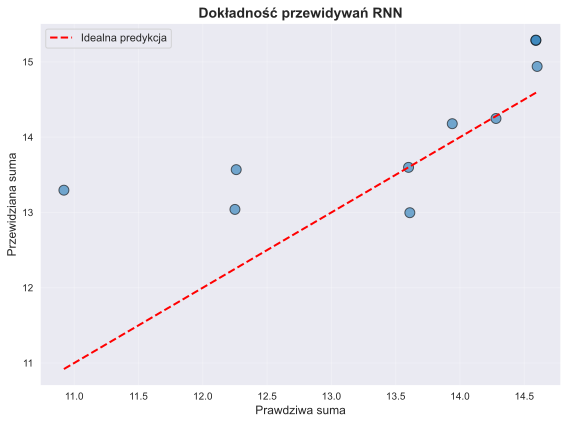

In [23]:
# Testowanie na nowych danych
print("=" * 70)
print("TESTOWANIE SIECI NA NOWYCH SEKWENCJACH")
print("=" * 70)

# Generuj nowe dane testowe
nb_test = 10
X_test, T_test = create_dataset(nb_test, sequence_len)

# Przewidywania
Y_test = RNN.getOutput(X_test)

print(f"\n{'Nr':<4} {'Sekwencja':<60} {'Suma':<8} {'Przewid.':<10} {'Błąd':<8} {'Błąd %':<8}")
print("-" * 110)

total_abs_error = 0
total_rel_error = 0

for i in range(nb_test):
    # Formatowanie sekwencji
    seq_str = ' '.join([f'{x:.2f}' for x in X_test[i, :, 0]])
    true_sum = T_test[i, 0]
    pred_sum = Y_test[i, 0]
    abs_error = abs(pred_sum - true_sum)
    rel_error = (abs_error / true_sum) * 100
    
    total_abs_error += abs_error
    total_rel_error += rel_error
    
    print(f"{i+1:<4} {seq_str:<60} {true_sum:<8.2f} {pred_sum:<10.2f} {abs_error:<8.3f} {rel_error:<8.2f}%")

print("-" * 110)
print(f"\nŚREDNIE BŁĘDY:")
print(f"  - Błąd bezwzględny: {total_abs_error/nb_test:.4f}")
print(f"  - Błąd względny: {total_rel_error/nb_test:.2f}%")
print(f"\nStrata testowa (MSE): {RNN.loss(Y_test, T_test):.6f}")

# Wizualizacja: prawda vs przewidywanie
plt.figure(figsize=(8, 6))
plt.scatter(T_test, Y_test, alpha=0.6, s=100, edgecolors='black', linewidths=1)
plt.plot([T_test.min(), T_test.max()], [T_test.min(), T_test.max()], 
         'r--', linewidth=2, label='Idealna predykcja')
plt.xlabel('Prawdziwa suma', fontsize=12)
plt.ylabel('Przewidziana suma', fontsize=12)
plt.title('Dokładność przewidywań RNN', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Analiza działania RNN - wizualizacja stanów ukrytych

### Po co?
Chcemy zobaczyć, **jak RNN "myśli"** podczas przetwarzania sekwencji.

### Co wizualizujemy?
- **Stany ukryte** $s_0, s_1, ..., s_{20}$ dla przykładowej sekwencji
- Każdy stan to wektor 5-wymiarowy
- Pokazujemy, jak ewoluują w czasie

### Co powinniśmy zaobserwować?
- Stany zmieniają się w czasie (RNN akumuluje informację)
- Ostatni stan $s_{20}$ powinien "kodować" sumę całej sekwencji

Analiza stanów ukrytych dla przykładowej sekwencji

Sekwencja wejściowa: [0.33 1.   0.33 0.66 0.66 1.   0.33 0.66 1.   1.   1.   0.33 0.33 1.
 1.   0.66 0.66 0.33 1.   0.33]
Prawdziwa suma: 13.61
Przewidywana suma: 13.00

Kształt tensorów:
  Wejście (X): (1, 20, 1)
  Stany (S): (1, 21, 5)  <- 21 stanów (s_0 do s_20)
  Wyjście (Y): (1, 1)


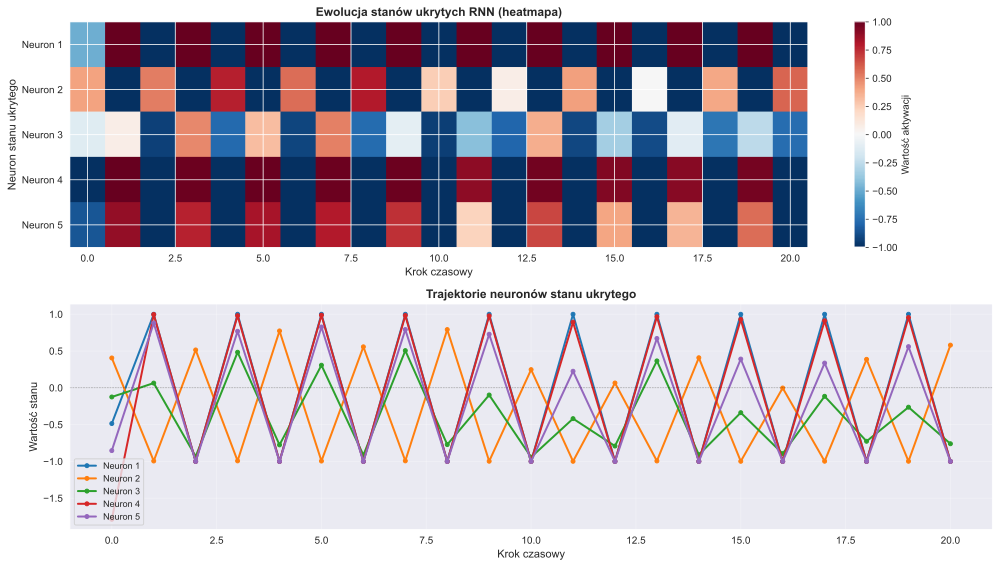


INTERPRETACJA:
• Każdy kolor/linia reprezentuje jeden neuron w stanie ukrytym
• Wartości [-1, 1] dzięki funkcji tanh
• Stan ZMIENIA SIĘ w czasie → RNN akumuluje informację
• Ostatni stan (krok 20) jest używany do predykcji sumy
• Różne neurony mogą specjalizować się w różnych aspektach zadania


In [24]:
# Wizualizacja stanów ukrytych RNN
print("Analiza stanów ukrytych dla przykładowej sekwencji\n")

# Wybierz pierwszą sekwencję testową
example_idx = 0
X_example = X_test[example_idx:example_idx+1, :, :]
T_example = T_test[example_idx:example_idx+1, :]

# Forward pass - zapisz stany
recIn, S, Z, Y = RNN.forward(X_example)

print(f"Sekwencja wejściowa: {X_example[0, :, 0]}")
print(f"Prawdziwa suma: {T_example[0, 0]:.2f}")
print(f"Przewidywana suma: {Y[0, 0]:.2f}")
print(f"\nKształt tensorów:")
print(f"  Wejście (X): {X_example.shape}")
print(f"  Stany (S): {S.shape}  <- 21 stanów (s_0 do s_20)")
print(f"  Wyjście (Y): {Y.shape}")

# Wykres: ewolucja stanów ukrytych
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))

# Wykres 1: Heatmapa stanów
states_matrix = S[0, :, :].T  # (5 neuronów × 21 kroków czasowych)
im1 = ax1.imshow(states_matrix, aspect='auto', cmap='RdBu_r', 
                 interpolation='nearest', vmin=-1, vmax=1)
ax1.set_xlabel('Krok czasowy', fontsize=11)
ax1.set_ylabel('Neuron stanu ukrytego', fontsize=11)
ax1.set_title('Ewolucja stanów ukrytych RNN (heatmapa)', 
              fontsize=12, fontweight='bold')
ax1.set_yticks(range(5))
ax1.set_yticklabels([f'Neuron {i+1}' for i in range(5)])
plt.colorbar(im1, ax=ax1, label='Wartość aktywacji')

# Wykres 2: Trajektorie poszczególnych neuronów
for neuron_idx in range(5):
    ax2.plot(range(21), S[0, :, neuron_idx], marker='o', 
             label=f'Neuron {neuron_idx+1}', linewidth=2, markersize=4)
ax2.set_xlabel('Krok czasowy', fontsize=11)
ax2.set_ylabel('Wartość stanu', fontsize=11)
ax2.set_title('Trajektorie neuronów stanu ukrytego', 
              fontsize=12, fontweight='bold')
ax2.legend(loc='best', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0, color='k', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)
print("INTERPRETACJA:")
print("=" * 70)
print("• Każdy kolor/linia reprezentuje jeden neuron w stanie ukrytym")
print("• Wartości [-1, 1] dzięki funkcji tanh")
print("• Stan ZMIENIA SIĘ w czasie → RNN akumuluje informację")
print("• Ostatni stan (krok 20) jest używany do predykcji sumy")
print("• Różne neurony mogą specjalizować się w różnych aspektach zadania")

## WNIOSKI KOŃCOWE

### 1. Czy RNN nauczyło się sumowania?
**TAK!** Sieć skutecznie nauczyła się sumować sekwencje 20 liczb z małym błędem.

### 2. Kluczowe mechanizmy sukcesu:

#### a) **Pamięć rekurencyjna**
- Stan ukryty $s_t$ przechowuje informację o wszystkich poprzednich wejściach
- Wzór: $s_t = \tanh(x_t + W \cdot s_{t-1} + b)$ łączy przeszłość z teraźniejszością
- Ostatni stan $s_{20}$ zawiera "skompresowaną" informację o całej sekwencji

#### b) **Współdzielone wagi**
- Te same parametry $W, b$ w każdym kroku czasowym
- Pozwala uczyć się uniwersalnego wzorca agregacji
- Mniej parametrów = łatwiej trenować, mniejsze ryzyko overfittingu

#### c) **Backpropagation Through Time (BPTT)**
- Gradient płynie wstecz przez wszystkie kroki czasowe
- Umożliwia uczenie się długoterminowych zależności
- **Problem:** Może prowadzić do zanikającego/eksplodującego gradientu

#### d) **Adaptacyjna optymalizacja (RMSprop + Nesterov)**
- RMSprop: automatyczna normalizacja kroków dla każdego parametru
- Nesterov: lepsze "przewidywanie" kierunku, szybsza zbieżność
- Razem: stabilny i efektywny trening

### 3. Wpływ komponentów:

| Komponent | Wpływ | Co by się stało bez tego? |
|-----------|-------|---------------------------|
| **TanH** | Nieliniowość, zakres [-1,1] | Tylko relacje liniowe, zanikający gradient |
| **Stan początkowy S0** | Punkt startowy "pamięci" | Gorsze wyniki, wolniejsza zbieżność |
| **RMSprop** | Adaptacyjne kroki | Niestabilny trening, trudna konwergencja |
| **Momentum** | Przyspieszenie, unikanie minimów lokalnych | Wolniejsza zbieżność, zatrzymanie w płaskich regionach |

### 4. Ograniczenia tego podejścia:

- **Zanikający gradient**: Dla bardzo długich sekwencji (>50 kroków) gradient może zaniknąć
- **Rozwiązanie**: LSTM lub GRU (bramki uczące się, co pamiętać)
- **Mały zbiór treningowy**: 30 próbek to niewiele - ryzyko overfittingu
- **Proste zadanie**: Sumowanie to zadanie liniowe - bardziej złożone wzorce byłyby trudniejsze

### 5. Zastosowania praktyczne RNN:

- **Szeregi czasowe**: Przewidywanie cen akcji, pogody
- **Przetwarzanie języka**: Tłumaczenie maszynowe, generowanie tekstu
- **Analiza sekwencji**: Rozpoznawanie mowy, analiza DNA
- **Kontrola**: Systemy decyzyjne zależne od historii

### 6. Dlaczego to działa lepiej niż zwykła sieć?

**Feed-forward**: Każdy krok czasowy przetwarzany NIEZALEŻNIE  
→ Brak kontekstu, nie może "zapamiętać" poprzednich wartości

**RNN**: Stan $s_t$ niesie informację przez czas  
→ Może akumulować, integrować dane z wielu kroków czasowych

### 7. Najważniejsze odkrycia:

1. **RNN = pamięć**: Stan ukryty to "krótkoterminowa pamięć" sieci
2. **Współdzielone wagi = generalizacja**: Uczy się wzorca, nie konkretnych przykładów
3. **Gradient through time**: Uczenie wymaga propagacji wstecz przez CAŁĄ sekwencję
4. **Adaptacyjna optymalizacja**: Kluczowa dla stabilnego treningu

---

### Podsumowanie jednym zdaniem:
**RNN nauczyło się sumować dzięki pamięci rekurencyjnej, która akumuluje informacje przez czas, trenowane efektywnie przez backpropagation through time z adaptacyjną optymalizacją.**